In [30]:
import numpy as np
import pandas as pd
import hashlib

import matplotlib.pyplot as plt
from matplotlib import cm

#files_in = ['./data/dlc/e3v813a-20210610T120637-121213DLC_resnet_50_pilot_studyJun15shuffle1_40000_bx_filtered.csv',
#            './data/dlc/e3v813a-20210610T121558-122141DLC_resnet_50_pilot_studyJun15shuffle1_40000_bx_filtered.csv',
#            './data/dlc/e3v813a-20210610T122332-122642DLC_resnet_50_pilot_studyJun15shuffle1_40000_bx_filtered.csv',
#            './data/dlc/e3v813a-20210610T122758-123309DLC_resnet_50_pilot_studyJun15shuffle1_40000_bx_filtered.csv',
#            './data/dlc/e3v813a-20210610T123521-124106DLC_resnet_50_pilot_studyJun15shuffle1_40000_bx_filtered.csv']

files_in = ['./data/dlc_w_crop/e3v813a-20210610T120637-121213DLC_resnet50_pilot_studyJun15shuffle1_50000_el_filtered.csv',
            './data/dlc_w_crop/e3v813a-20210610T122758-123309DLC_resnet50_pilot_studyJun15shuffle1_50000_el_filtered.csv',
            './data/dlc_w_crop/e3v813a-20210610T121558-122141DLC_resnet50_pilot_studyJun15shuffle1_50000_el_filtered.csv',
            './data/dlc_w_crop/e3v813a-20210610T123521-124106DLC_resnet50_pilot_studyJun15shuffle1_50000_el_filtered.csv',
            './data/dlc_w_crop/e3v813a-20210610T122332-122642DLC_resnet50_pilot_studyJun15shuffle1_50000_el_filtered.csv']

fn_out = '/mnt/storage2/blansdel/projects/mabe_final/mabetask1_ml/data/test_inference.npy'

In [2]:
test_out = {'sequences':{}}

In [44]:
fn_in = files_in[0]

df = pd.read_csv(fn_in, header = [0,1,2,3])
df.isna().sum()

scorer                                       individuals  bodyparts  coords          0
DLC_resnet50_pilot_studyJun15shuffle1_50000  adult        nose       x             111
                                                                     y             111
                                                                     likelihood    111
                                                          leftear    x             212
                                                                     y             212
                                                                     likelihood    212
                                                          rightear   x              59
                                                                     y              59
                                                                     likelihood     59
                                                          neck       x              48
                                           

In [43]:
#Examine tracks for nose with different filterings
test_trace = df['DLC_resnet50_pilot_studyJun15shuffle1_50000']['juvenile'][['nose', 'leftear']]
test_trace#['diff'] = test_trace['nose'] - test_trace['leftear']

nose                        leftear                     
              x         y likelihood         x         y likelihood
0       704.268   977.844        1.0   753.024   979.283    1.00000
1       704.591   979.078        1.0   753.146   979.687    1.00000
2       708.350   979.078        1.0   753.146   979.760    1.00000
3       708.350   978.796        1.0   753.059   979.760    1.00000
4       708.350   978.796        1.0   753.059   979.283    1.00000
...         ...       ...        ...       ...       ...        ...
10075  1019.235  1063.106        1.0  1026.836  1020.720    0.99993
10076  1020.683  1064.582        1.0  1027.475  1026.025    0.99942
10077  1022.828  1067.496        1.0  1030.368  1026.678    0.99980
10078  1022.828  1067.496        1.0  1030.368  1026.678    0.99992
10079  1022.828  1067.496        1.0  1030.368  1026.678    0.99996

[10080 rows x 6 columns]

In [39]:
np.sum(test_trace['likelihood'] < 0.5)

268

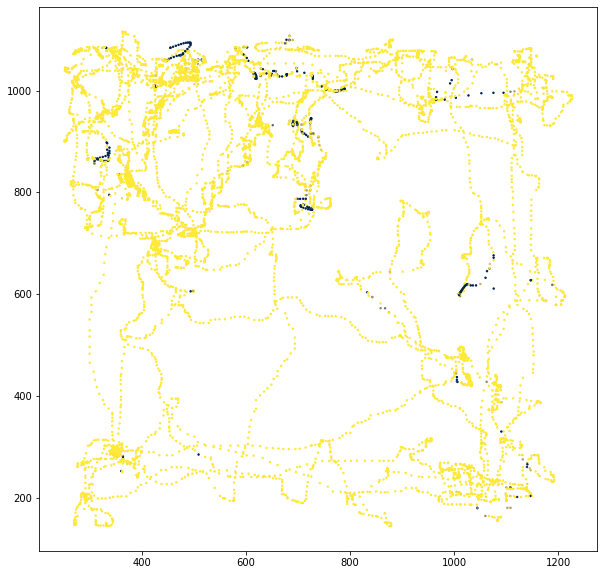

In [40]:
fig = plt.figure(figsize = (10,10))
cmap = plt.get_cmap('cividis')
plt.scatter(x = test_trace['x'], y = test_trace['y'], c = test_trace['likelihood'], s = 2, cmap = cmap)

## Add interpolation

In [57]:
df_interp = df.interpolate(axis = 0, method = 'polynomial', order = 3)
#df_interp.isna().sum()

In [58]:
#Examine tracks for nose with different filterings
test_trace_interp = df_interp['DLC_resnet50_pilot_studyJun15shuffle1_50000']['juvenile'][['nose', 'leftear']]
#test_trace_interp#['diff'] = test_trace['nose'] - test_trace['leftear']

(240.0, 1250.0)

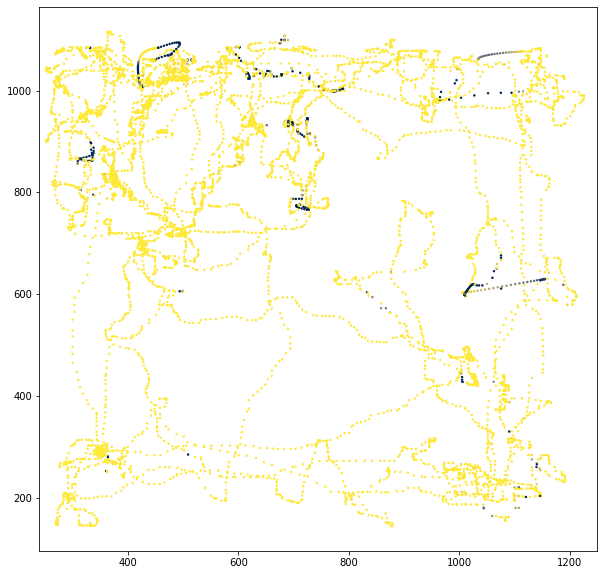

In [59]:
fig = plt.figure(figsize = (10,10))
cmap = plt.get_cmap('cividis')
lhood = np.clip(test_trace_interp['nose']['likelihood'], 0, 1)
plt.scatter(x = test_trace_interp['nose']['x'], y = test_trace_interp['nose']['y'], c = lhood, s = 2, cmap = cmap)
plt.xlim([240, 1250])

(240.0, 1250.0)

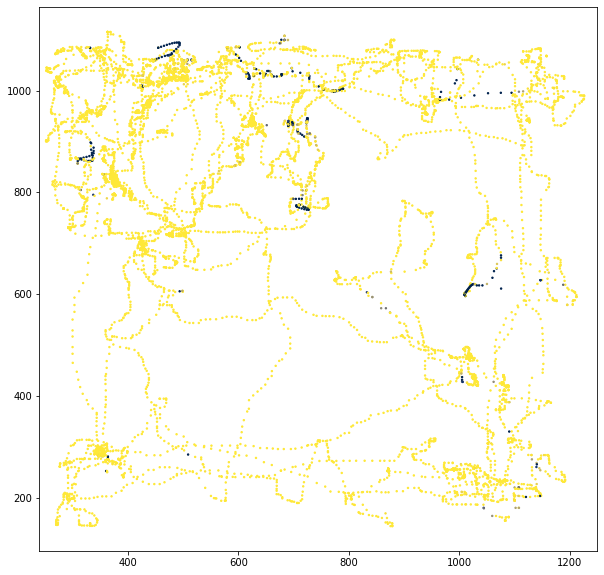

In [53]:
fig = plt.figure(figsize = (10,10))
cmap = plt.get_cmap('cividis')
plt.scatter(x = test_trace['nose']['x'], y = test_trace['nose']['y'], c = test_trace['nose']['likelihood'], s = 2, cmap = cmap)
plt.xlim([240, 1250])

## Filter over low confidence predictions too

In [144]:
df_filter_low_conf = df['DLC_resnet50_pilot_studyJun15shuffle1_50000'].copy()
df_filter_low_conf = df_filter_low_conf.sort_index()

mice = ['juvenile', 'adult']
bodyparts = ['nose', 'leftear', 'rightear', 'neck', 'lefthip', 'righthip', 'tail']

threshold = 0.5

for m in mice:
    for bp in bodyparts:
        low_conf = df_filter_low_conf[m][bp]['likelihood'] < threshold
        df_filter_low_conf.loc[low_conf,(m, bp, 'x')] = np.nan
        df_filter_low_conf.loc[low_conf,(m, bp, 'y')] = np.nan
        df_filter_low_conf.loc[low_conf,(m, bp, 'likelihood')] = np.nan
        
#And now filter
df_filter_low_conf = df_filter_low_conf.interpolate(axis = 0, method = 'polynomial', order = 3)

test_trace_interp_lowconf = df_filter_low_conf['juvenile'][['nose', 'leftear']]


(240.0, 1250.0)

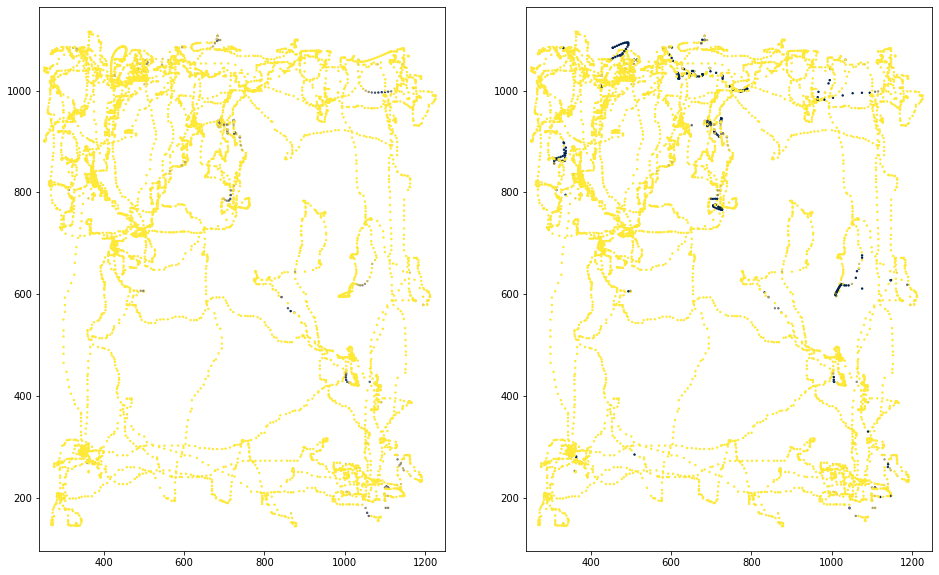

In [150]:
fig, axes = plt.subplots(1, 2, figsize = (16,10))
cmap = plt.get_cmap('cividis')
lhood = np.clip(test_trace_interp_lowconf['nose']['likelihood'], 0, 1)
axes[0].scatter(x = test_trace_interp_lowconf['nose']['x'], y = test_trace_interp_lowconf['nose']['y'], c = lhood, s = 2, cmap = cmap)
axes[0].set_xlim([240, 1250])

axes[1].scatter(x = test_trace['nose']['x'], y = test_trace['nose']['y'], c = test_trace['nose']['likelihood'], s = 2, cmap = cmap)
axes[1].set_xlim([240, 1250])

## Filter out frames where velocity or distance of relative body parts it too high... (a crude Kalman filter) 